# Final Project - Predicting Fat Content in Cheeses
#### By: Stephen Yee

## Introduction

Retail consumers are more health-conscious than ever and pay more and more attention to the characteristics of the food they put in their bodies. One food characteristic that health-conscious shoppers may pay attention to is the amount of fat in different foods.

The goal of this analysis will be to evaluate whether a type of cheese's different features can predict whether it is a higher fat or lower fat product. This type of analysis is best suited to a classification analysis since we want to predict whether a given cheese will be `lower fat` (our positive class) or `higher fat` (our negative class).

## Exploratory Data Analysis

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import string
import scipy
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from scipy.stats import lognorm, loguniform, randint

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

First we will import our dataset called `cheese_data.csv`.

In [2]:
cheese_df = pd.read_csv("data/cheese_data.csv")
cheese_df.head()

CheeseId ManufacturerProvCode ManufacturingTypeEn  MoisturePercent  \
0       228                   NB           Farmstead             47.0   
1       242                   NB           Farmstead             47.9   
2       301                   ON          Industrial             54.0   
3       303                   NB           Farmstead             47.0   
4       319                   NB           Farmstead             49.4   

                                          FlavourEn  \
0                                     Sharp, lactic   
1                Sharp, lactic, lightly caramelized   
2                           Mild, tangy, and fruity   
3  Sharp with fruity notes and a hint of wild honey   
4                                      Softer taste   

                                   CharacteristicsEn  Organic  \
0                                           Uncooked        0   
1                                           Uncooked        0   
2  Pressed and cooked cheese, pasta filata, inter...        0   
3                                                NaN        0   
4                                                NaN        1   

     CategoryTypeEn MilkTypeEn MilkTreatmentTypeEn   RindTypeEn  \
0       Firm Cheese        Ewe            Raw Milk  Washed Rind   
1  Semi-soft Cheese        Cow            Raw Milk  Washed Rind   
2       Firm Cheese        Cow         Pasteurized          NaN   
3    Veined Cheeses        Cow            Raw Milk          NaN   
4  Semi-soft Cheese        Cow            Raw Milk  Washed Rind   

                           CheeseName   FatLevel  
0             Sieur de Duplessis (Le)  lower fat  
1                 Tomme Le Champ Doré  lower fat  
2  Provolone Sette Fette (Tre-Stelle)  lower fat  
3                      Geai Bleu (Le)  lower fat  
4                          Gamin (Le)  lower fat

We can visualize our data to understand its characteristics in two ways by using `info()` and `describe()`.

In [3]:
cheese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   int64  
 7   CategoryTypeEn        1019 non-null   object 
 8   MilkTypeEn            1041 non-null   object 
 9   MilkTreatmentTypeEn   977 non-null    object 
 10  RindTypeEn            721 non-null    object 
 11  CheeseName            1042 non-null   object 
 12  FatLevel              1042 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 106.0+ KB


In [4]:
cheese_df.describe()

CheeseId  MoisturePercent      Organic
count  1042.000000      1028.000000  1042.000000
mean   1560.633397        47.069747     0.095010
std     451.811164         9.592647     0.293369
min     228.000000        12.000000     0.000000
25%    1280.250000        40.000000     0.000000
50%    1548.500000        46.000000     0.000000
75%    1901.750000        52.000000     0.000000
max    2391.000000        92.000000     1.000000

Since this is a classification problem, it could be helpful to see the value distirbution of unique values for some features. We will take a look at the distributions for the features with numeric values or discrete sets of possible categorical values: `ManufacturerProvCode`, `ManufacturingTypeEn`, `MoisturePercent`, `Organic`, `CategoryTypeEn`, `MilkTypeEn`, `MilkTreatmentTypeEn`, `RindTypeEn` and `FatLevel`.

In [5]:
manufacturerProvCode_chart = alt.Chart(cheese_df, width=700).mark_bar(color='orange').encode(
    x = alt.X('ManufacturerProvCode:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of ManufacturerProvCode values')
manufacturerProvCode_chart

alt.Chart(...)

In [6]:
manufacturingTypeEn_chart = alt.Chart(cheese_df, width=700).mark_bar(color='purple', size=100).encode(
    x = alt.X('ManufacturingTypeEn:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of ManufacturingTypeEn values')
manufacturingTypeEn_chart

alt.Chart(...)

In [7]:
moisture_chart = alt.Chart(cheese_df, width=700).mark_circle(size=150, opacity=.15, color='darkred').encode(
    x = alt.X('MoisturePercent:Q')).properties(title='Distribution of MositurePercent values')
moisture_chart

alt.Chart(...)

In [8]:
organic_chart = alt.Chart(cheese_df, width=700).mark_bar(color='black', size=100).encode(
    x = alt.X('Organic:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of organic values')
organic_chart

alt.Chart(...)

In [9]:
categoryType_chart = alt.Chart(cheese_df, width=700).mark_bar(color='green').encode(
    x = alt.X('CategoryTypeEn:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of CategoryTypeEn values')
categoryType_chart

alt.Chart(...)

In [10]:
milkTypeEn_chart = alt.Chart(cheese_df, width=700).mark_bar(color='grey', size=100).encode(
    x = alt.X('MilkTypeEn:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of MilkTypeEn values')
milkTypeEn_chart

alt.Chart(...)

In [11]:
milkTreatmentTypeEn_chart = alt.Chart(cheese_df, width=700).mark_bar(color='lightblue', size=100).encode(
    x = alt.X('MilkTreatmentTypeEn:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of MilkTreatmentTypeEn values')
milkTreatmentTypeEn_chart

alt.Chart(...)

In [12]:
rindTypeEn_chart = alt.Chart(cheese_df, width=700).mark_bar(color='gold', size=100).encode(
    x = alt.X('RindTypeEn:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of RindTypeEn values')
rindTypeEn_chart

alt.Chart(...)

In [13]:
fatLevel_chart = alt.Chart(cheese_df, width=700).mark_bar(width=100, color='darkblue').encode(
    x = alt.X('FatLevel:N'),
    y = alt.Y('count(y):Q')
).properties(title='Frequency of FatLevel values')
fatLevel_chart

alt.Chart(...)

Since IDs and names are unique to each cheese and are not useful if scaled, and are not as useful in semantically identifying a given cheese as its name, we are just going to drop these features from our dataset.

Because of the extremely high level of variability in the `FlavourEn` and `CharacteristicsEn` values, along with the significant number of missing values in each, we are going to drop these features as well since One Hot Encoding would result in hundreds of unique values for each.

In [14]:
reduced_cheese_df = cheese_df.drop(columns=['CheeseId', 'FlavourEn', 'CharacteristicsEn', 'CheeseName'])
reduced_cheese_df.head()

ManufacturerProvCode ManufacturingTypeEn  MoisturePercent  Organic  \
0                   NB           Farmstead             47.0        0   
1                   NB           Farmstead             47.9        0   
2                   ON          Industrial             54.0        0   
3                   NB           Farmstead             47.0        0   
4                   NB           Farmstead             49.4        1   

     CategoryTypeEn MilkTypeEn MilkTreatmentTypeEn   RindTypeEn   FatLevel  
0       Firm Cheese        Ewe            Raw Milk  Washed Rind  lower fat  
1  Semi-soft Cheese        Cow            Raw Milk  Washed Rind  lower fat  
2       Firm Cheese        Cow         Pasteurized          NaN  lower fat  
3    Veined Cheeses        Cow            Raw Milk          NaN  lower fat  
4  Semi-soft Cheese        Cow            Raw Milk  Washed Rind  lower fat

Now we will split our data into train and test sets. This will allow us to train our data without comprimising our ability to evaluate the success of our model later on — the golden rule of machine learning. We will reserve 20% of our dataset to be used for testing.

In [15]:
X = reduced_cheese_df.drop(columns='FatLevel')
y = reduced_cheese_df['FatLevel']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((833, 8), (833,), (209, 8), (209,))

### Dataset Analysis
The data in the cheese dataset is heavily categorical. The only `int` or `float` features are `CheeseID` (which is not a meaningful feautre for prediction), `MoisturePercent`, and and `Organic` (which is actually an integer representation of a binary feature).

Some of the features such as `FlavourEn`, `CharacteristicsEn`, `MilkTreatmentTypeEn` and `RindType` have a significant number of null datapoints. It will be questionable to impute some of the more heavily text-based fields since things like falvour profiles can be so drastically different. There will likely be very few examples that have the same value for `FlavourEn` or `CharacteristicsEn`. For this reason, we previously dropped `CheeseID`, `FlavourEn` and `CharacteristicsEn` from the dataframe.

At first glance, it is not obvious whether any of the features will be obviously related to the target of `FatLevel`. 

There is a mild class imbalance in the target feature, with nearly twice as many lower fat cheeses than higher fat ones, however the imbalance is not so great that it jeopardizes the feasibility of the train/test split.

For a health-conscious buyer, accidentally buying a higher fat cheese would be worse than accidentally buying a low fat cheese, so it is important that our model correctly predicts the positive class (i.e., lower fat cheese). With that in mind, precision will be in important measure of success for our model. Accuracy may also provide beneficial context, although since the classes are slightly imbalanced, accuracy becomes less reliable.

## Preprocessing

Now that we've split our data, we need to clean and preprocess it.

To start, lets split our data into numeric, binary and categorical features. There are no ordinal features in this dataset. Because `CheeseName` is unique to each row, it won't be useful to our model. We will leave this out of any of the categories and use the `remainder='passthrough'` feature when building our column transformer.

In [17]:
numeric_features= ['MoisturePercent'] 
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn',
                     'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn',
                     'RindTypeEn']
binary_features = ['Organic']

Now we need to create our column transformers for each data type.

For the numeric column, `MoisturePercent`, there are relatively few NaN values, so we can use a simple median for imputation. We'll also use a StandardScaler.

In [18]:
numeric_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

Since we dropped the highly irregular data columns that were missing many values earlier, we can use a simple ipmutation method on the remaining categorical columns. We'll use a "most frequent" strategy here. 

Since there are no ordinal values in these columns, we will use One Hot Encoding to transform the values into numerical values.

In [19]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(dtype=int, handle_unknown='ignore')
)

Finally, for the binary feature, we can again use the same transformer as categorical information, but drop the second binary column produced by One Hot Encoding since it is just the inverse of the first column.

In [20]:
binary_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(dtype=int, drop="if_binary")
)

Now that we've built our transmormers, we can build our entire preprocessor.

In [21]:
preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        (binary_transformer, binary_features),
)

## Methods & Results

We have done all the work to clean the data and transform it. Now we can incorporate our preprocessor into various classification models. We will evaluate a few different models to see which performs the best. We will evaluate:
- Dummy Classifier
- Logstic Regression
- k-Nearest Neighbours
- SVMs with RBF Kernel

In [22]:
dummy_pipeline = make_pipeline(preprocessor, DummyClassifier(strategy='most_frequent'))
dummy_pipeline.fit(X_train, y_train)
dummy_pipeline.score(X_train, y_train)

0.65906362545018

A score of 66 aligns with what we saw in the visualization of the `FatLevel` values.

For our linear model, we will use logistic regression since our target is not a numerical value.

In [23]:
linear_pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
linear_pipeline.fit(X_train, y_train)

linear_train_score = linear_pipeline.score(X_train, y_train)
print(linear_train_score)

linear_test_score = linear_pipeline.score(X_test, y_test)
print(linear_test_score)

0.8187274909963985
0.7655502392344498


In [24]:
knn_pipeline = make_pipeline(preprocessor, KNeighborsClassifier())
knn_pipeline.fit(X_train, y_train)

knn_train_score = knn_pipeline.score(X_train, y_train)
print("knn_train_score: " + str(knn_train_score))

knn_test_score = knn_pipeline.score(X_test, y_test)
print("knn_test_score: " + str(knn_test_score))

knn_train_score: 0.8703481392557023
knn_test_score: 0.8086124401913876


In [25]:
svm_pipeline = make_pipeline(preprocessor, SVC())
svm_pipeline.fit(X_train, y_train)

svm_train_score = svm_pipeline.score(X_train, y_train)
print("svm_train_score: " + str(svm_train_score))

svm_test_score = svm_pipeline.score(X_test, y_test)
print("svm_test_score: " + str(svm_test_score))

svm_train_score: 0.8415366146458584
svm_test_score: 0.7799043062200957


All three non-dummy models performed much better than the Dummy Classifier. But let's tune their hyperparamaters and see if we can make them even better. To do this, we will use randomized search cross validation across many possible hyperparameter values.

For the Logistic Regression, we will start with a wide range of possible C values.

In [26]:
linear_param_grid_wide = {
    "logisticregression__C": scipy.stats.uniform(0.001, 100)}

wide_linear_search = RandomizedSearchCV(linear_pipeline, linear_param_grid_wide, n_jobs=-1, cv=10, return_train_score=True, n_iter = 10, random_state=23)
wide_linear_search.fit(X_train, y_train)

best_linear_params_wide = wide_linear_search.best_params_['logisticregression__C']
print('best_c_wide:' + str(best_linear_params_wide))

best_c_wide:51.73078838465892


In [27]:
wide_linear_pipeline = make_pipeline(preprocessor, LogisticRegression(C=best_linear_params_wide, max_iter=1000))
wide_linear_pipeline.fit(X_train, y_train)

wide_linear_pipeline_train_score = wide_linear_pipeline.score(X_train, y_train)
print(wide_linear_pipeline_train_score)

wide_linear_pipeline_test_score = wide_linear_pipeline.score(X_test, y_test)
print(wide_linear_pipeline_test_score)

0.8175270108043218
0.7511961722488039


The wide range resulted in significant overfitting. Let's retry with a narrower range of values.

In [28]:
linear_param_grid_medium = {
    "logisticregression__C": scipy.stats.uniform(0.01, 10)}

mid_linear_search = RandomizedSearchCV(linear_pipeline, linear_param_grid_medium, n_jobs=-1, cv=10, return_train_score=True, n_iter = 10, random_state=23)
mid_linear_search.fit(X_train, y_train)

best_linear_params_mid = mid_linear_search.best_params_['logisticregression__C']
print("best_c_mid: " + str(best_linear_params_mid))

best_c_mid: 1.6813920310005626


In [29]:
mid_linear_pipeline = make_pipeline(preprocessor, LogisticRegression(C=best_linear_params_mid, max_iter=1000))
mid_linear_pipeline.fit(X_train, y_train)

mid_linear_train_score = mid_linear_pipeline.score(X_train, y_train)
print(mid_linear_train_score)

mid_linear_test_score = mid_linear_pipeline.score(X_test, y_test)
print(mid_linear_test_score)

0.8163265306122449
0.7655502392344498


The medium range of C values still resulted in pretty significant overfitting of the model. Let's try once more time with an even narrower range of values.

In [30]:
linear_param_grid_narrow = {
    "logisticregression__C": scipy.stats.uniform(0.001, 0.01)}

narrow_linear_search = RandomizedSearchCV(linear_pipeline, linear_param_grid_narrow, n_jobs=-1, cv=10, return_train_score=True, n_iter = 10, random_state=23)
narrow_linear_search.fit(X_train, y_train)

best_linear_params_narrow = narrow_linear_search.best_params_['logisticregression__C']
print("best_c_narrow: " + str(best_linear_params_narrow))

best_c_narrow: 0.01046962603814814


In [31]:
narrow_linear_pipeline = make_pipeline(preprocessor, LogisticRegression(C=best_linear_params_narrow, max_iter=1000))
narrow_linear_pipeline.fit(X_train, y_train)

best_narrow_linear_train_score = narrow_linear_pipeline.score(X_train, y_train)
print("best_narrow_linear_train_score: " + str(best_narrow_linear_train_score))

best_narrow_linear_test_score = narrow_linear_pipeline.score(X_test, y_test)
print("best_narrow_linear_test_score: " + str(best_narrow_linear_test_score))

best_narrow_linear_train_score: 0.8079231692677071
best_narrow_linear_test_score: 0.8038277511961722


The narrow paramater grid appears to have improved both the test score and the amount of overfitting!

Now we will tune the k-Nearest Neighbors model's hyperparameters.

In [32]:
knn_param_grid_low_k = {
    "kneighborsclassifier__n_neighbors": np.arange(1,25)
}

knn_search_low_k= RandomizedSearchCV(knn_pipeline, knn_param_grid_low_k, n_jobs=-1, cv=10, return_train_score=True, n_iter=10, random_state=23)
knn_search_low_k.fit(X_train, y_train)

best_knn_params_low = knn_search_low_k.best_params_['kneighborsclassifier__n_neighbors']
print("best_n_neighbors_low_k: " + str(best_knn_params_low))

best_n_neighbors_low_k: 5


In [33]:
low_k_pipeline = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=best_knn_params_low))
low_k_pipeline.fit(X_train, y_train)

best_low_k_pipeline_train_score = low_k_pipeline.score(X_train, y_train)
print("low_k_pipeline train score: " + str(best_low_k_pipeline_train_score))

best_low_k_pipeline_test_score = low_k_pipeline.score(X_test, y_test)
print("mid_k_pipeline test score: " + str(best_low_k_pipeline_test_score))

low_k_pipeline train score: 0.8703481392557023
mid_k_pipeline test score: 0.8086124401913876


The low k range appears slightly overfit. Let's try with the medium and high ranges to see if one produces less overfitting.

In [34]:
knn_param_grid_mid_k = {
    "kneighborsclassifier__n_neighbors": np.arange(50,100)
}

knn_search_mid_k= RandomizedSearchCV(knn_pipeline, knn_param_grid_mid_k, n_jobs=-1, cv=10, return_train_score=True, n_iter=10, random_state=23)
knn_search_mid_k.fit(X_train, y_train)

best_knn_params_mid = knn_search_mid_k.best_params_['kneighborsclassifier__n_neighbors']
print("best_n_neighbors_mid_k: " + str(best_knn_params_mid))

best_n_neighbors_mid_k: 58


In [35]:
mid_k_pipeline = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=best_knn_params_mid))
mid_k_pipeline.fit(X_train, y_train)

best_mid_k_pipeline_train_score = mid_k_pipeline.score(X_train, y_train)
print("mid_k_pipeline train score: " + str(best_mid_k_pipeline_train_score))

best_mid_k_pipeline_test_score = mid_k_pipeline.score(X_test, y_test)
print("mid_k_pipeline test score: " + str(best_mid_k_pipeline_test_score))

mid_k_pipeline train score: 0.7935174069627852
mid_k_pipeline test score: 0.8038277511961722


The medium range of k values has produced a much smaller gap between the train and test scores compared to the low range k parameters. In fact, the test score is actually higher than the train score.

Lets do one more test with the high range. Since the range is much larger, let's also increase the `n_iter` value for this one.

In [36]:
knn_param_grid_high_k = {
    "kneighborsclassifier__n_neighbors": np.arange(100,500)
}

knn_search_high_k= RandomizedSearchCV(knn_pipeline, knn_param_grid_high_k, n_jobs=-1, cv=10, return_train_score=True, n_iter=25, random_state=23)
knn_search_high_k.fit(X_train, y_train)

best_knn_params_high = knn_search_high_k.best_params_['kneighborsclassifier__n_neighbors']
print("best_n_neighbors_high_k: " + str(best_knn_params_high))

best_n_neighbors_high_k: 159


In [37]:
high_k_pipeline = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=best_knn_params_high))
high_k_pipeline.fit(X_train, y_train)

best_high_k_pipeline_train_score = high_k_pipeline.score(X_train, y_train)
print("high_k_pipeline train score: " + str(best_high_k_pipeline_train_score))

best_high_k_pipeline_test_score = high_k_pipeline.score(X_test, y_test)
print("high_k_pipeline test score: " + str(best_high_k_pipeline_test_score))

high_k_pipeline train score: 0.7839135654261705
high_k_pipeline test score: 0.7942583732057417


The gap between the train and test scores is even thinner with the high k range, but the scores have also gone down slightly. Overall, there is not a huge difference between the medium and high ranges of k, so we will move forward with the medium one since it is more efficient in terms of computing resources.

Let's now tune the SVM model. We will start by using a wide range of numbers from 0.001 to 100 for both the C and gamma hyperparameters.

In [38]:
svm_param_grid_wide = {
    "svc__gamma": scipy.stats.uniform(0.001, 100),
    "svc__C": scipy.stats.uniform(0.001, 100),
}

wide_svm_search = RandomizedSearchCV(svm_pipeline, svm_param_grid_wide, n_jobs=-1, cv=10, return_train_score=True, n_iter=25, verbose=1, random_state=23)
wide_svm_search.fit(X_train, y_train)

best_svm_params_wide = wide_svm_search.best_params_
print('best_svm_params_wide: ' + str(best_svm_params_wide))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
best_svm_params_wide: {'svc__C': 11.048771391367378, 'svc__gamma': 0.053881116927605555}


In [39]:
wide_svm_pipeline = make_pipeline(preprocessor, SVC(gamma=best_svm_params_wide['svc__gamma'], C=best_svm_params_wide['svc__C']))
wide_svm_pipeline.fit(X_train, y_train)

best_wide_svm_pipeline_train_score = wide_svm_pipeline.score(X_train, y_train)
print('wide_svm_pipeline train score: ' + str(best_wide_svm_pipeline_train_score))

best_wide_svm_pipeline_test_score = wide_svm_pipeline.score(X_test, y_test)
print('wide_svm_pipeline test score: ' + str(best_wide_svm_pipeline_test_score))

wide_svm_pipeline train score: 0.8523409363745498
wide_svm_pipeline test score: 0.7703349282296651


We can see that with the wide range, these parameters result in a fair bit of overfitting.

Let's retry with different ranges to reduce overfitting.

In [40]:
svm_param_grid_medium = {
    "svc__gamma": scipy.stats.uniform(0.01, 10),
    "svc__C": scipy.stats.uniform(0.01, 10),
}

medium_svm_search = RandomizedSearchCV(svm_pipeline, svm_param_grid_medium, n_jobs=-1, cv=10, return_train_score=True, n_iter=25, verbose=1, random_state=23)
medium_svm_search.fit(X_train, y_train)

best_svm_params_medium = medium_svm_search.best_params_
print("best_svm_params_medium: " + str(best_svm_params_medium))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
best_svm_params_medium: {'svc__C': 1.1147771391367378, 'svc__gamma': 0.015288111692760556}


In [41]:
medium_svm_pipeline = make_pipeline(preprocessor, SVC(gamma=best_svm_params_medium['svc__gamma'], C=best_svm_params_medium['svc__C']))
medium_svm_pipeline.fit(X_train, y_train)

best_medium_svm_pipeline_train_score = medium_svm_pipeline.score(X_train, y_train)
print('best_medium_svm_pipeline_train_score: ' + str(best_medium_svm_pipeline_train_score))

best_medium_svm_pipeline_test_score = medium_svm_pipeline.score(X_test, y_test)
print('best_medium_svm_pipeline_test_score: ' + str(best_medium_svm_pipeline_test_score))

best_medium_svm_pipeline_train_score: 0.8115246098439376
best_medium_svm_pipeline_test_score: 0.7655502392344498


This gave us better results than the wide number range, but there is still a bit of overfitting.

Lets try with an even narrower number range.

In [42]:
svm_param_grid_narrow = {
    "svc__gamma": scipy.stats.uniform(0.01, 0.1),
    "svc__C": scipy.stats.uniform(0.01, 0.1),
}

narrow_svm_search = RandomizedSearchCV(svm_pipeline, svm_param_grid_narrow, n_jobs=-1, cv=10, return_train_score=True, n_iter=25, verbose=1, random_state=23)
narrow_svm_search.fit(X_train, y_train)

best_svm_params_narrow = narrow_svm_search.best_params_
print("best_svm_params_narrow: " + str(best_svm_params_narrow))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
best_svm_params_narrow: {'svc__C': 0.09224663391034331, 'svc__gamma': 0.0726183037960246}


In [43]:
narrow_svm_pipeline = make_pipeline(preprocessor, SVC(gamma=best_svm_params_narrow['svc__gamma'], C=best_svm_params_narrow['svc__C']))
narrow_svm_pipeline.fit(X_train, y_train)

best_mid_svm_pipeline_train_score = narrow_svm_pipeline.score(X_train, y_train)
print('narrow_svm_pipeline train score: ' + str(best_mid_svm_pipeline_train_score))

best_mid_svm_pipeline_test_score = narrow_svm_pipeline.score(X_test, y_test)
print('narrow_svm_pipeline test score: ' + str(best_mid_svm_pipeline_test_score))

narrow_svm_pipeline train score: 0.8175270108043218
narrow_svm_pipeline test score: 0.7894736842105263


We've found a range where the scores didn't deteriorate, but the overfitting reduced even further.

As a recap, we've identified that the medium KNN hyperparameters and the narrow Logistic Regression and SVM hyperparameters produced the best models. Lets  evaluate these models further with a confusion matrix.

In [44]:
linear_predictions = narrow_linear_pipeline.predict(X_test)
pd.Series(linear_predictions).head()

0    lower fat
1    lower fat
2    lower fat
3    lower fat
4    lower fat
dtype: object

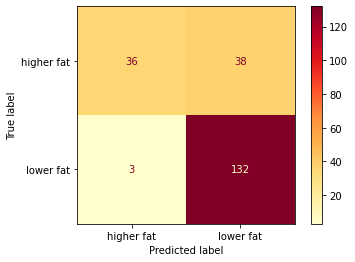

In [45]:
plot_confusion_matrix(narrow_linear_pipeline, X_test, y_test,
                      cmap="YlOrRd")

In [46]:
linear_TN, linear_FP, linear_FN, linear_TP = confusion_matrix(y_test, linear_predictions).ravel()
linear_TN, linear_FP, linear_FN, linear_TP

(36, 38, 3, 132)

In [47]:
linear_accuracy = (linear_TP + linear_TN)/(linear_TP + linear_FP + linear_TN + linear_FN)
linear_accuracy

0.8038277511961722

In [48]:
linear_precision = linear_TP/(linear_TP + linear_FP)
linear_precision

0.7764705882352941

In [49]:
knn_predictions = mid_k_pipeline.predict(X_test)
pd.Series(knn_predictions).head()

0     lower fat
1    higher fat
2     lower fat
3     lower fat
4     lower fat
dtype: object

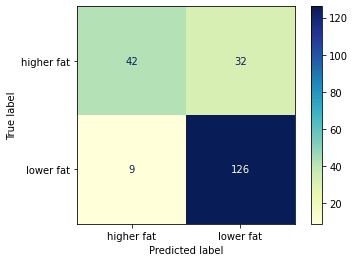

In [50]:
plot_confusion_matrix(mid_k_pipeline, X_test, y_test,
                      cmap="YlGnBu")

In [51]:
knn_TN, knn_FP, knn_FN, knn_TP = confusion_matrix(y_test, knn_predictions).ravel()
knn_TN, knn_FP, knn_FN, knn_TP

(42, 32, 9, 126)

In [52]:
knn_accuracy = (knn_TP + knn_TN)/(knn_TP + knn_FP + knn_TN + knn_FN)
knn_accuracy

0.8038277511961722

In [53]:
knn_precision = knn_TP/(knn_TP + knn_FP)
knn_precision

0.7974683544303798

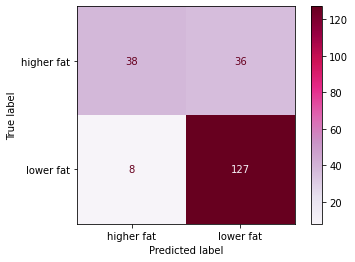

In [54]:
svm_predictions = narrow_svm_pipeline.predict(X_test)
plot_confusion_matrix(narrow_svm_pipeline, X_test, y_test,
                      cmap="PuRd")

In [55]:
svm_TN, svm_FP, svm_FN, svm_TP = confusion_matrix(y_test, svm_predictions).ravel()
svm_TN, svm_FP, svm_FN, svm_TP

(38, 36, 8, 127)

In [56]:
svm_accuracy = (svm_TP + svm_TN)/(svm_TP + svm_FP + svm_TN + svm_FN)
svm_accuracy

0.7894736842105263

In [57]:
svm_precision = svm_TP/(svm_TP + svm_FP)
svm_precision

0.7791411042944786

We can see here that both models do pretty well at correctly predicting our positive class:

In [58]:
scores_index = ['Linear', 'KNN', 'SVM']

accuracy_results = [linear_accuracy, knn_accuracy, svm_accuracy]

precision_results = [linear_precision, knn_precision, svm_precision]

untuned_train_scores = [
    linear_train_score,
    knn_train_score,
    svm_train_score
]

untuned_test_scores = [
    linear_test_score,
    knn_test_score,
    svm_test_score
]

tuned_train_scores = [
    best_narrow_linear_train_score,
    best_mid_k_pipeline_train_score,
    best_medium_svm_pipeline_train_score
]

tuned_test_scores = [
    best_narrow_linear_test_score,
    best_mid_k_pipeline_test_score,
    best_medium_svm_pipeline_test_score
]

model_results = {
    'accuracy': accuracy_results,
    'precision': precision_results,
    'untuned train scores': untuned_train_scores,
    'untuned test scores': untuned_test_scores,
    'tuned train scores': tuned_train_scores,
    'tuned test scores': tuned_test_scores
}

model_results_df = pd.DataFrame(data=model_results, index=scores_index)
model_results_df

accuracy  precision  untuned train scores  untuned test scores  \
Linear  0.803828   0.776471              0.818727             0.765550   
KNN     0.803828   0.797468              0.870348             0.808612   
SVM     0.789474   0.779141              0.841537             0.779904   

        tuned train scores  tuned test scores  
Linear            0.807923           0.803828  
KNN               0.793517           0.803828  
SVM               0.811525           0.765550

Overall, both models performed pretty well and were not overfitted once their hyperparameters were tuned. Either of these models would likely be suitable for predicting whether a type of cheese is lower fat or higher fat. The scores of the models with tuned hyperparameters were also as good (KNN) or better than (SVM) the untuned models.

## Discussion
The goal of this project was to develop a model that could predict whether a type of cheese is higher fat or lower fat. For health conscious shoppers, purchasing lower fat products could be a key factor in purchasing decisions.

Both the k-Nearest Neighbors and SVM models have accuracy and precision around 80%. Since precision "is useful when the cost of a false positive is high," it is typically beneficial when you "want to be confident in identifying the target class, even if you miss out on some (or many) instances" [(evidentlyai.com)](https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall). For someone with strong dietary preferences, it would be worse to accidentally buy a higher fat product than it would be to not identify some of the lower fat options available. This make precision an effective measure for the success of our model.



We can also review feature importances for all three models using `sklearn.inspection.permutation_importance`. This function is model agnostic and works by "randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score" [(scikit-learn.org)](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance). 

In [59]:
features = X_train.columns
features

Index(['ManufacturerProvCode', 'ManufacturingTypeEn', 'MoisturePercent',
       'Organic', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn',
       'RindTypeEn'],
      dtype='object')

In [60]:
linear_perm_importance = permutation_importance(narrow_linear_pipeline, X_train, y_train, random_state=23)
linear_perm_importance

{'importances_mean': array([9.36374550e-03, 1.00840336e-02, 1.50300120e-01, 2.22044605e-17,
        4.46578631e-02, 2.23289316e-02, 2.40096038e-04, 1.63265306e-02]),
 'importances_std': array([0.00375042, 0.00336134, 0.0089643 , 0.00131506, 0.00438792,
        0.00545393, 0.00334415, 0.00269507]),
 'importances': array([[ 0.0120048 ,  0.01440576,  0.00720288,  0.00360144,  0.00960384],
        [ 0.01560624,  0.00840336,  0.00840336,  0.0060024 ,  0.0120048 ],
        [ 0.15846339,  0.15726291,  0.14645858,  0.15486194,  0.13445378],
        [-0.00240096,  0.        ,  0.        ,  0.00120048,  0.00120048],
        [ 0.03721489,  0.05042017,  0.04681873,  0.04561825,  0.04321729],
        [ 0.02881152,  0.01920768,  0.02881152,  0.01920768,  0.01560624],
        [-0.00360144, -0.00240096,  0.00480192,  0.00360144, -0.00120048],
        [ 0.01680672,  0.02040816,  0.01680672,  0.01560624,  0.0120048 ]])}

In [61]:
knn_perm_importance = permutation_importance(mid_k_pipeline, X_train, y_train, random_state=23)
knn_perm_importance

{'importances_mean': array([ 0.00312125,  0.02472989,  0.12869148, -0.00720288,  0.00192077,
         0.0060024 ,  0.00552221,  0.00672269]),
 'importances_std': array([0.00318523, 0.00664507, 0.00676543, 0.00075925, 0.00327447,
        0.00200879, 0.00247194, 0.00344603]),
 'importances': array([[-0.00120048,  0.        ,  0.00480192,  0.00480192,  0.00720288],
        [ 0.02160864,  0.02040816,  0.03481393,  0.030012  ,  0.01680672],
        [ 0.14045618,  0.12244898,  0.12364946,  0.13205282,  0.12484994],
        [-0.00720288, -0.00840336, -0.00720288, -0.00720288, -0.0060024 ],
        [ 0.        ,  0.00480192, -0.00360144,  0.00480192,  0.00360144],
        [ 0.00360144,  0.00480192,  0.00840336,  0.00840336,  0.00480192],
        [ 0.00840336,  0.00720288,  0.00480192,  0.00120048,  0.0060024 ],
        [ 0.00960384,  0.00720288,  0.01080432,  0.00480192,  0.00120048]])}

In [62]:
svm_perm_importance = permutation_importance(narrow_svm_pipeline, X_train, y_train, random_state=23)
svm_perm_importance

{'importances_mean': array([ 0.00744298,  0.02328932,  0.14885954, -0.0002401 ,  0.02953181,
         0.0180072 ,  0.00792317,  0.02064826]),
 'importances_std': array([0.00232782, 0.00122425, 0.00552743, 0.00048019, 0.00561024,
        0.00563075, 0.00384154, 0.00511579]),
 'importances': array([[ 0.00480192,  0.00840336,  0.00480192,  0.01080432,  0.00840336],
        [ 0.02280912,  0.0240096 ,  0.02280912,  0.02160864,  0.02521008],
        [ 0.15486194,  0.14885954,  0.14765906,  0.15366146,  0.1392557 ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -0.00120048],
        [ 0.02761104,  0.02761104,  0.03841537,  0.02160864,  0.03241297],
        [ 0.0240096 ,  0.01560624,  0.02521008,  0.01440576,  0.01080432],
        [ 0.00480192,  0.00480192,  0.01320528,  0.0120048 ,  0.00480192],
        [ 0.02040816,  0.030012  ,  0.01920768,  0.01920768,  0.01440576]])}

In [63]:
importance_data = {
    'Linear': linear_perm_importance['importances_mean'],
    'KNN': knn_perm_importance['importances_mean'],
    'SVM': svm_perm_importance['importances_mean']
}

pd.options.display.float_format = '{:.5f}'.format
feature_importance_df = pd.DataFrame(data=importance_data, index=features)
feature_importance_df

Linear      KNN      SVM
ManufacturerProvCode 0.00936  0.00312  0.00744
ManufacturingTypeEn  0.01008  0.02473  0.02329
MoisturePercent      0.15030  0.12869  0.14886
Organic              0.00000 -0.00720 -0.00024
CategoryTypeEn       0.04466  0.00192  0.02953
MilkTypeEn           0.02233  0.00600  0.01801
MilkTreatmentTypeEn  0.00024  0.00552  0.00792
RindTypeEn           0.01633  0.00672  0.02065

`MoisturePercent` is by far the most important feature for all three models. None of the other features in the models were consistently important, though `ManufacturingTypeEn` and `CategoryTypeEn` were somewhat important. It is interesting that the only numeric feature is the most important in determining the target value. 


There were not many limitations to these models. We were able to develop two different models with fairly high precision and accuracy. If we were trying to answer a more life-and-death question, the levels of precision and accuracy likely wouldn't be sufficient, but buying cheese is thankfully a relatively low risk endeavour. If we had a larger dataset or more discrete features, this potentially would have helped increase scores of our models.

One other idea I considered trying was using CountVectorizer() to see if the descriptions in `FlavourEn` and `CharacteristicsEn` were able to reliably predict the target value, however due to the very large number of NaN values and no way to valuably impute those missing values, this was not a realistic model to build.

Overall, this project was successful in creating two models that could be used to predict whether a cheese is lower or higher fat.

## References
- [Intro to Machine Learning - Modules 1-8](https://intro-machine-learning.netlify.app/)
- [scikit-learn](https://scikit-learn.org/)
- [NumPy](https://numpy.org/doc/stable/)
- [Altair Viz](https://altair-viz.github.io/user_guide/api.html)
- [SciPy](https://docs.scipy.org/doc/scipy/tutorial/index.html)
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)
- [evidentlyai.com - Accuracy, Precision and Recall](https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall)